In [1]:
contact_id = "SkySat-B-rev9161-Tro01-1"

In [2]:
from math import pi,radians,sqrt,cos,sin,tan,atan
import datetime
import httplib
import json

import numpy
import matplotlib
from matplotlib import pyplot

from ma_utils2 import MissionArchive
from orbitology.SatelliteClasses import SatelliteTime

In [3]:
EARTH_RADIUS = 6378.137
EARTH_ECCENTRICITY = 0.08181919084

KILO = 1000

SATELLITES = {
    1: ["SkySat-A","b"],
    2: ["SkySat-B","g"]
}

GROUND_STATIONS = { 
    "Fbx01": {
        "lat":   64.81317,#deg
        "lon": -147.73312,#deg
        "alt": 150.49#m
    },
    "Tro01": {
        "lat":   69.66201,#deg
        "lon":   18.93973,#deg
        "alt": 147.88#m
    }
}


COMMANDING_LIMIT = -20

GEODETIC_TO_GEOCENTRIC = lambda R,e:\
                         lambda lat,lon,alt:\
                         numpy.array([(R / sqrt(1 - e ** 2 * sin(lat) ** 2) + alt) * cos(lat) * cos(lon),
                                      (R / sqrt(1 - e ** 2 * sin(lat) ** 2) + alt) * cos(lat) * sin(lon),
                                      (R / sqrt(1 - e ** 2 * sin(lat) ** 2) * (1 - e ** 2) + alt) * sin(lat)])

NEXUS_HOST = 'nexus.prod.pdx1.skybox.com'
JANUS_HOST = 'janus.prod.pdx1.skybox.com'
OSIRIS_REST_API = "/osiris-rest-api/v1/%s?%s"

In [4]:
ma = MissionArchive(NEXUS_HOST)

matplotlib.rcParams['figure.figsize'] = [10, 10]

In [5]:
yavin_query = " ".join(["select satellitenumber",
                        ",groundstationid",
                        ",starttime",
                        ",endtime",
                        "from contact",
                        "where id = '%s'",
                        "order by _key desc"]) % (contact_id,)

data = ma.skyql_stream(yavin_query)
contact = data['rows'][0]

satellite = SATELLITES[contact["satellitenumber"]][0]
ground_station = GROUND_STATIONS[contact["groundstationid"]]
start_time = SatelliteTime(contact["starttime"],"UNIX_MS")
end_time = SatelliteTime(contact["endtime"],"UNIX_MS")

Returned data with length 423 from Nexus in 0:00:00.027471


In [6]:
observer = GEODETIC_TO_GEOCENTRIC(EARTH_RADIUS,EARTH_ECCENTRICITY)(radians(ground_station["lat"]),
                                                                   radians(ground_station["lon"]),
                                                                   ground_station["alt"] / KILO)

In [7]:
nexus_conn = httplib.HTTPConnection(JANUS_HOST,8082)

try:
    ephem = dict()
    for scid in SATELLITES:
        osiris_request = "/".join(["satellite","%s",
                                   "ephemerides"]) % (SATELLITES[scid][0])
            
        nexus_conn.request("GET",OSIRIS_REST_API % (osiris_request,""))
        
        ephemeris_response = nexus_conn.getresponse()
        
        if ephemeris_response.status == httplib.OK:
            ephemeris_data = json.loads(ephemeris_response.read())["ephemerides"]
            
            for row in ephemeris_data:
                ephem_start = datetime.datetime.strptime(row["time_range"]["start"],"%Y-%m-%dT%H:%M:%S.%fZ")
                ephem_stop = datetime.datetime.strptime(row["time_range"]["stop"],"%Y-%m-%dT%H:%M:%S.%fZ")
                                                         
                ephem_start = SatelliteTime(ephem_start,"DATETIME")
                ephem_stop = SatelliteTime(ephem_stop,"DATETIME")
                version = row["version"]
                
                if ephem_start.datetime < end_time.datetime and\
                   ephem_stop.datetime > start_time.datetime:
                    break
            else:
                raise Exception, "No ephemeris available!"
            
        
        osiris_request = "/".join(["satellite","%s",
                                   "time-system","%s",
                                   "start-time","%s",
                                   "end-time","%s",
                                   "time-step-sec","%d",
                                   "position"]) % (SATELLITES[scid][0],
                                                   "UTC",
                                                   start_time.utc,
                                                   end_time.utc,
                                                   10)
        osiris_query = "frame=ECEF&units=KILOMETER&version=%d" % version
                
        nexus_conn.request("GET",OSIRIS_REST_API % (osiris_request,osiris_query))
        
        position_response = nexus_conn.getresponse()
    
        if position_response.status == httplib.OK:
            position_data = json.loads(position_response.read())["positions"]
            
            ephem[SATELLITES[scid][0]] = numpy.array([[state["position"][0],
                                                       state["position"][1],
                                                       state["position"][2]] \
                                                      for state in position_data])
except Exception, error:
    print error.message

nexus_conn.close()

### Ground Station Command Cone

/opt/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


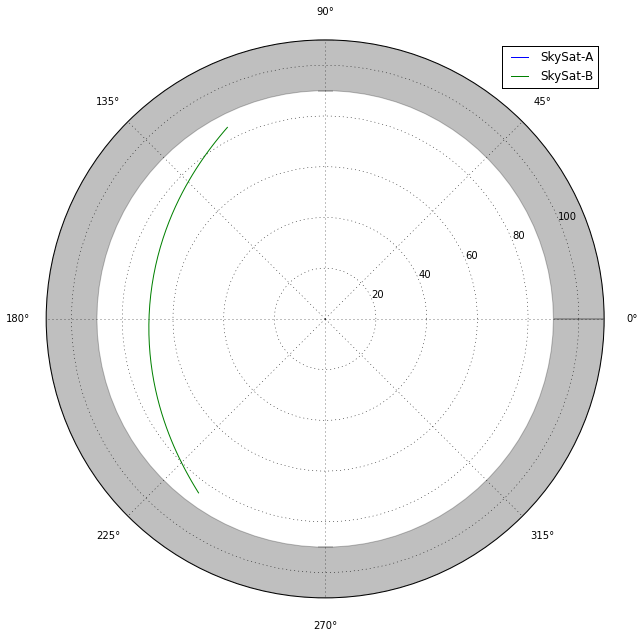

In [8]:
cos_ph = cos(radians(ground_station["lat"]))
sin_ph = sin(radians(ground_station["lat"]))
cos_th = cos(radians(ground_station["lon"]))
sin_th = sin(radians(ground_station["lon"]))

Q = numpy.array([[-sin_th,cos_th,0],
                 [-sin_ph * cos_th,-sin_ph * sin_th,cos_ph],
                 [cos_ph * cos_th,cos_ph * sin_th,sin_ph]])


ax = pyplot.subplot(111,polar=True)

topo_horz_coord = dict()

for scid in SATELLITES:
    topo_horz_coord[SATELLITES[scid][0]] = numpy.einsum("ij,kj->ki",
                                                        Q,ephem[SATELLITES[scid][0]] - observer)
    
    az = numpy.arctan2(topo_horz_coord[SATELLITES[scid][0]][:,1],
                       topo_horz_coord[SATELLITES[scid][0]][:,0])
    el = numpy.arctan2(numpy.hypot(topo_horz_coord[SATELLITES[scid][0]][:,0],
                                   topo_horz_coord[SATELLITES[scid][0]][:,1]),
                       topo_horz_coord[SATELLITES[scid][0]][:,2])
    
    ax.plot(az,numpy.degrees(el),
            color=SATELLITES[scid][1],
            label=SATELLITES[scid][0])
else:
    ax.fill_between(numpy.radians(numpy.arange(0,361,4)),
                    90*numpy.ones(91),
                    (90+20)*numpy.ones(91),
                    color="k",alpha=0.25)

ax.set_rmax(90+20)
ax.set_rmin(0)

ax.legend(*ax.get_legend_handles_labels())

### Status Messages

In [9]:
failed = False

for scid in SATELLITES:
    if SATELLITES[scid][0] != satellite:
        el = numpy.degrees(numpy.arctan2(topo_horz_coord[SATELLITES[scid][0]][:,2],
                                         numpy.hypot(topo_horz_coord[SATELLITES[scid][0]][:,0],
                                                     topo_horz_coord[SATELLITES[scid][0]][:,1])))
        
        if numpy.any(el > COMMANDING_LIMIT):
            print "\tWARNING, %s is less than %d degrees from the horizon of %s!" % (SATELLITES[scid][0], 
                                                                                   COMMANDING_LIMIT,
                                                                                   contact["groundstationid"])
            
            failed = True
else:
    if failed is True:
        print "DO NOT SEND HARDWARE COMMANDS!"
    else:
        print "OK to send hardware commands!"

OK to send hardware commands!
